# Autoregression Exercise

Roadmap for autoregression analysis

### 1. Download dataset from Kaggle

In [57]:
import os
import zipfile
import pandas as pd

initial_working_directory = os.getcwd()

kaggle_dataset = "piyushagni5/monthly-sales-of-french-champagne"

kaggle_json_path = '<path_to_kaggle_json>' # replace with path to your kaggle.json file

os.environ['KAGGLE_CONFIG_DIR'] = kaggle_json_path

target_dir = os.path.join('<base_path>', 'Kaggle', kaggle_dataset) # replace <base_path> with desired base directory

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

os.chdir(target_dir)

In [58]:
!kaggle datasets download -d {kaggle_dataset}

monthly-sales-of-french-champagne.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
dataset_filename = kaggle_dataset.split('/')[-1]

with zipfile.ZipFile(f'{dataset_filename}.zip', 'r') as zip_ref:
    zip_ref.extractall()

### 2. Load dataset

In [61]:
df = pd.read_csv('monthly_champagne_sales.csv')

In [62]:
os.chdir(initial_working_directory)

### 3. Exploratory Data Analysis

In [64]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [65]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [66]:
df.index.freq = 'MS'

In [67]:
df.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq='MS')

In [68]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [70]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<Axes: xlabel='Month'>

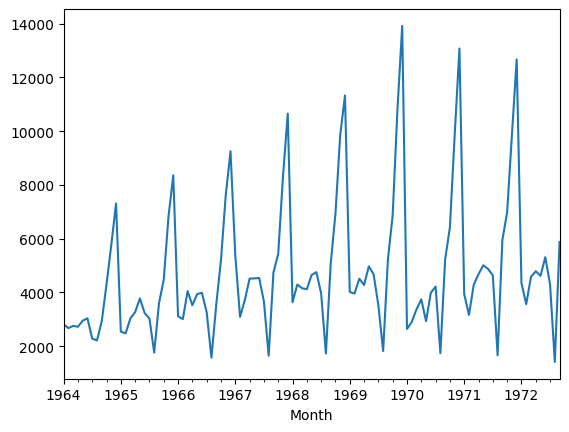

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df['Sales'].plot()

<Axes: >

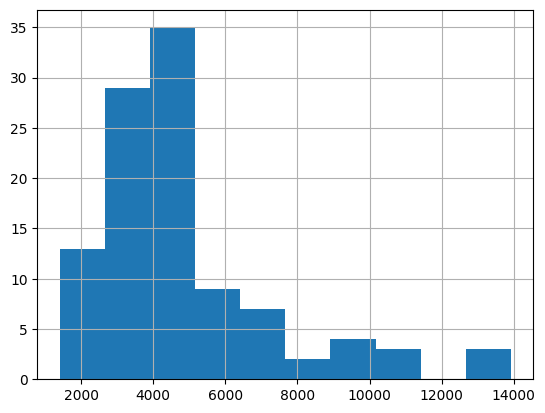

In [72]:
df['Sales'].hist()

<Axes: xlabel='Sales', ylabel='Density'>

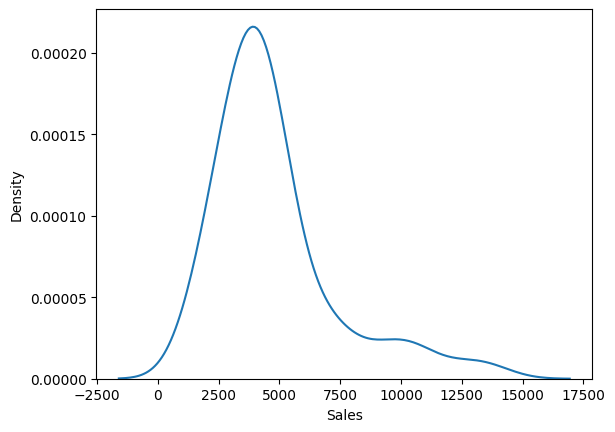

In [73]:
sns.kdeplot(df['Sales'])

<Axes: title={'center': 'Sales'}, xlabel='Year'>

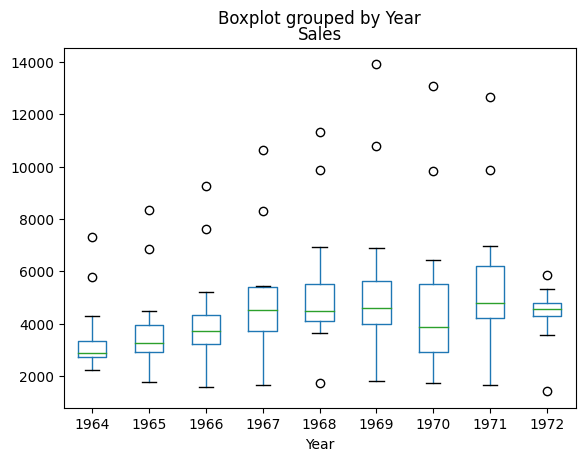

In [74]:
df['Year'] = df.index.year

df.boxplot(by='Year', column='Sales', grid=False)

In [75]:
df = df.drop('Year', axis=1)

In [76]:
df.columns

Index(['Sales'], dtype='object')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

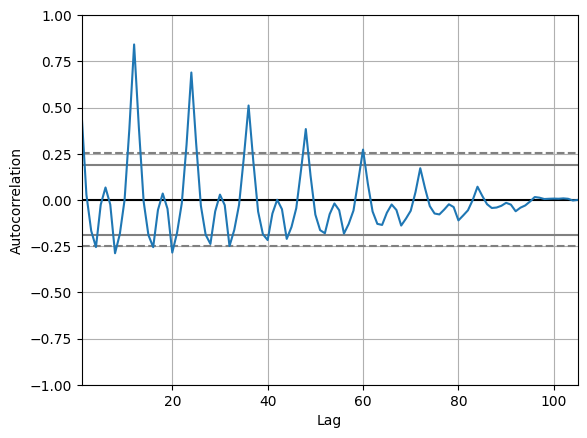

In [77]:
pd.plotting.autocorrelation_plot(df['Sales'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

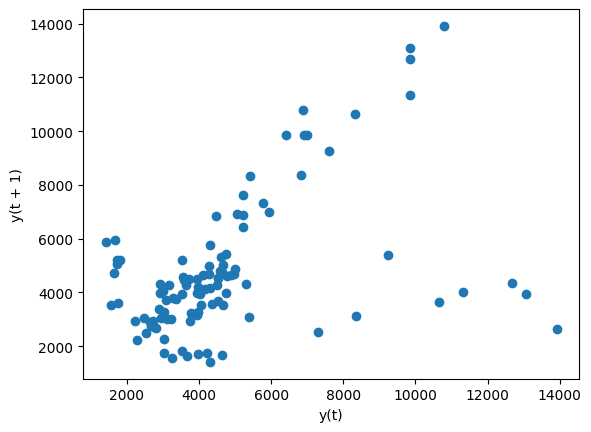

In [78]:
pd.plotting.lag_plot(df['Sales'])

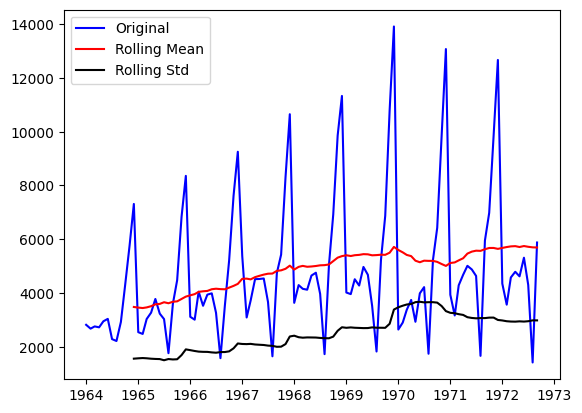

In [79]:
rolling_mean = df['Sales'].rolling(window=12).mean()
rolling_std = df['Sales'].rolling(window=12).std()
plt.plot(df['Sales'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')

### 4. Data cleaning

In [80]:
print(df.isnull().sum())

Sales    0
dtype: int64


### 5. ETS assessment

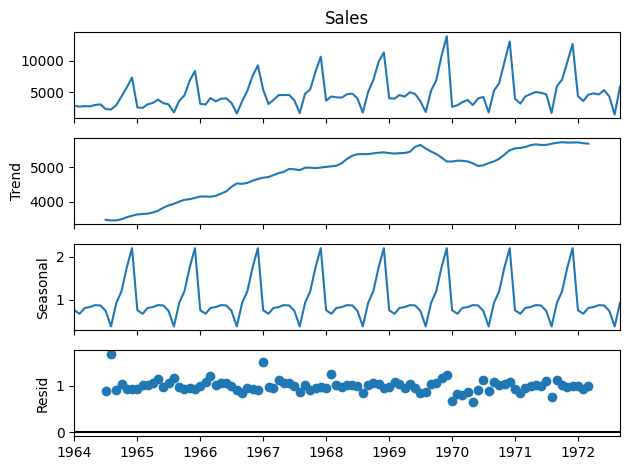

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Sales'], model='multiplicative')  

result.plot();

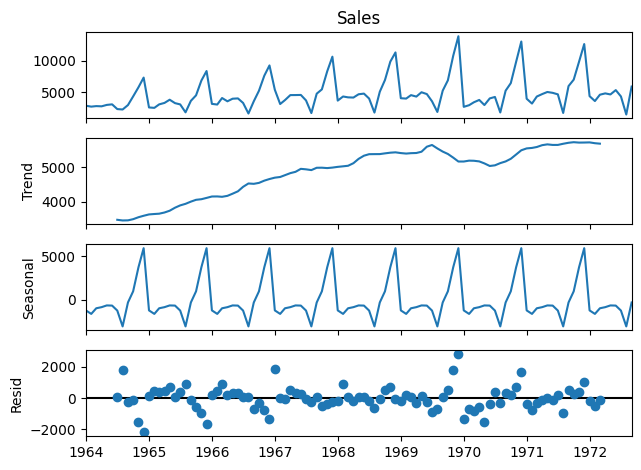

In [82]:
result = seasonal_decompose(df['Sales'], model='additive')  

result.plot();

### 6. Stationarity check

In [83]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [84]:
adf_test(df['Sales'], 'Monthly sales of French champagne')

Augmented Dickey-Fuller Test: Monthly sales of French champagne
ADF test statistic      -1.833593
p-value                  0.363916
# lags used             11.000000
# observations          93.000000
critical value (1%)     -3.502705
critical value (5%)     -2.893158
critical value (10%)    -2.583637
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [85]:
df_diff = df.diff().dropna()

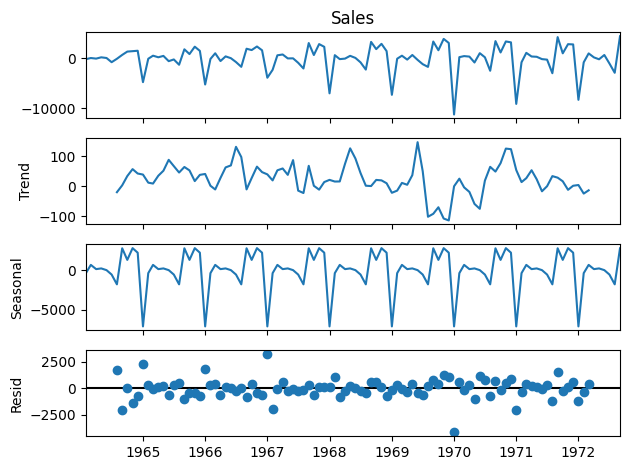

In [86]:
result_diff = seasonal_decompose(df_diff['Sales'], model='additive')  

result_diff.plot();

In [87]:
adf_test(df_diff['Sales'], 'Monthly sales of French champagne')

Augmented Dickey-Fuller Test: Monthly sales of French champagne
ADF test statistic     -7.189896e+00
p-value                 2.519620e-10
# lags used             1.100000e+01
# observations          9.200000e+01
critical value (1%)    -3.503515e+00
critical value (5%)    -2.893508e+00
critical value (10%)   -2.583824e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [88]:
import numpy as np
df_log = np.log(df).dropna()

In [89]:
adf_test(df_log['Sales'], 'Monthly sales of French champagne')

Augmented Dickey-Fuller Test: Monthly sales of French champagne
ADF test statistic      -2.255119
p-value                  0.186852
# lags used             13.000000
# observations          91.000000
critical value (1%)     -3.504343
critical value (5%)     -2.893866
critical value (10%)    -2.584015
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [90]:
df_old = df

In [91]:
df = df_diff

### 6. Split dataset

In [94]:
train = df[:int(0.8*(len(df)))]
test = df[int(0.8*(len(df))):]

In [95]:
print(len(train))
print(len(test))

83
21


### 7. ACF and PACF

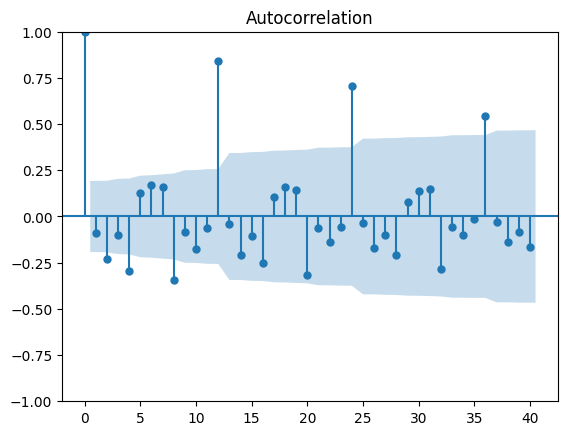

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Sales'], lags=40);

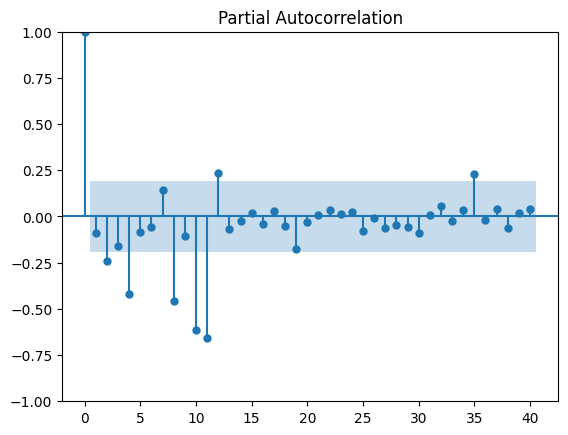

In [101]:
plot_pacf(df['Sales'], lags=40);

### 8. Define model, fit, and take predictions

In [103]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=[2,4,8,10,11,12,35])

In [104]:
model_fit = model.fit()

In [105]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

### 9. Plot predictions

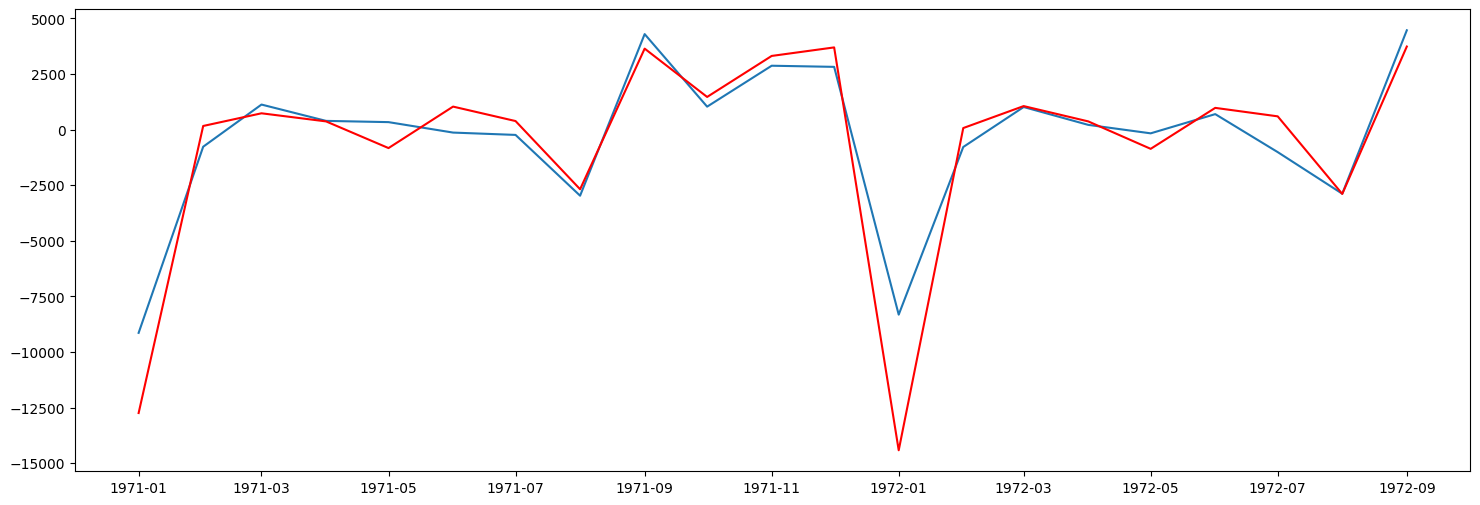

In [107]:
plt.figure(figsize=(18,6))
plt.plot(test)
plt.plot(predictions, color='red')

### 10. Evaluate model performance

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, mean_tweedie_deviance
from math import sqrt

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
medae = median_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
evs = explained_variance_score(test, predictions)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MedAE': medae,
    'R2 score': r2,
    'Explained Variance Score': evs
}

df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

df_metrics

,Value
MSE,2.877445e+06
RMSE,1.696303e+03
MAE,1.003898e+03
MedAE,6.533348e+02
R2 score,7.356084e-01
Explained Variance Score,7.423090e-01


### 11. Residual diagnostics

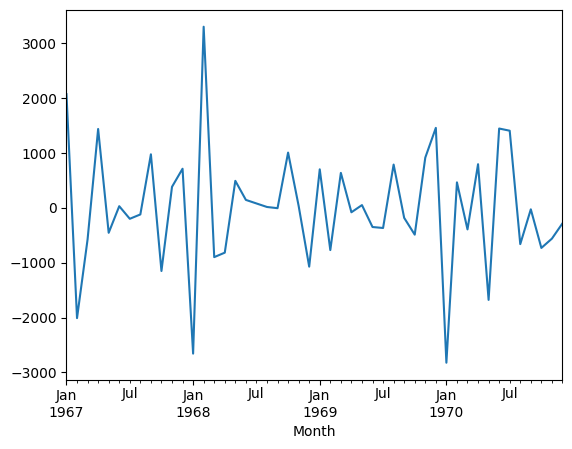

In [119]:
residuals = model_fit.resid
residuals.plot();

### 12. Compare with other models

In [124]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order=(2,0,2))
model_arima_fit = model_arima.fit()

predictions_arima = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

C:\Users\fmiranda\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fmiranda\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [125]:
mse_arima = mean_squared_error(test, predictions_arima)
rmse_arima = sqrt(mse_arima)
mae_arima = mean_absolute_error(test, predictions_arima)
medae_arima = median_absolute_error(test, predictions_arima)
r2_arima = r2_score(test, predictions_arima)
evs_arima = explained_variance_score(test, predictions_arima)

metrics_arima = {
    'MSE': mse_arima,
    'RMSE': rmse_arima,
    'MAE': mae_arima,
    'MedAE': medae_arima,
    'R2 score': r2_arima,
    'Explained Variance Score': evs_arima
}

df_metrics_arima = pd.DataFrame.from_dict(metrics_arima, orient='index', columns=['ARIMA'])
df_metrics_combined = pd.concat([df_metrics, df_metrics_arima], axis=1)
df_metrics_combined.columns = ['AutoReg', 'ARIMA']
print(df_metrics_combined)

                               AutoReg         ARIMA
MSE                       2.877445e+06  9.012255e+06
RMSE                      1.696303e+03  3.002042e+03
MAE                       1.003898e+03  2.115904e+03
MedAE                     6.533348e+02  1.106203e+03
R2 score                  7.356084e-01  1.719166e-01
Explained Variance Score  7.423090e-01  1.722794e-01


### 13. Use auto_arima to automatically identify best parameters

In [126]:
from pmdarima import auto_arima

model_auto_arima = auto_arima(train, start_p=0, start_q=0, test='adf', max_p=6, max_q=6, m=12, d=None, seasonal=True, start_P=0, D=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1487.390, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1533.882, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1532.096, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1407.141, Time=0.23 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1405.333, Time=0.65 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1408.553, Time=0.57 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,0,0)(2,0,1)[12]             : AIC=1402.111, Time=0

In [128]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(train, order=(0,0,0), seasonal_order=(2,0,1,12))
model_sarimax_fit = model_sarimax.fit(disp=False)

predictions_sarimax = model_sarimax_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

C:\Users\fmiranda\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\fmiranda\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [129]:
mse_sarimax = mean_squared_error(test, predictions_sarimax)
rmse_sarimax = sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(test, predictions_sarimax)
medae_sarimax = median_absolute_error(test, predictions_sarimax)
r2_sarimax = r2_score(test, predictions_sarimax)
evs_sarimax = explained_variance_score(test, predictions_sarimax)

metrics_sarimax = {
    'MSE': mse_sarimax,
    'RMSE': rmse_sarimax,
    'MAE': mae_sarimax,
    'MedAE': medae_sarimax,
    'R2 score': r2_sarimax,
    'Explained Variance Score': evs_sarimax
}

df_metrics_sarimax = pd.DataFrame.from_dict(metrics_sarimax, orient='index', columns=['SARIMAX'])
df_metrics_combined = pd.concat([df_metrics, df_metrics_arima, df_metrics_sarimax], axis=1)
df_metrics_combined.columns = ['AutoReg', 'ARIMA', 'SARIMAX']
print(df_metrics_combined)

                               AutoReg         ARIMA        SARIMAX
MSE                       2.877445e+06  9.012255e+06  583321.816949
RMSE                      1.696303e+03  3.002042e+03     763.755077
MAE                       1.003898e+03  2.115904e+03     630.773737
MedAE                     6.533348e+02  1.106203e+03     575.824823
R2 score                  7.356084e-01  1.719166e-01       0.946402
Explained Variance Score  7.423090e-01  1.722794e-01       0.946408


### 14. Model implementation and future predictions

In [149]:
model_final = AutoReg(df, lags=[2,4,8,10,11,12,35])
model_final_fit = model_final.fit()

In [153]:
forecast_diff = model_final_fit.predict(start=len(df), end=len(df)+11)

In [162]:
forecast = pd.concat([df_old.iloc[-1], forecast_diff]).cumsum()

print(forecast[-12:])

1972-10-01 00:00:00     7255.408761
1972-11-01 00:00:00    10169.465911
1972-12-01 00:00:00    11777.432259
1973-01-01 00:00:00     3809.990722
1973-02-01 00:00:00     2737.511984
1973-03-01 00:00:00     4069.880213
1973-04-01 00:00:00     4235.503123
1973-05-01 00:00:00     4414.763740
1973-06-01 00:00:00     5361.223049
1973-07-01 00:00:00     3811.853163
1973-08-01 00:00:00      916.428758
1973-09-01 00:00:00     5584.598708
dtype: float64


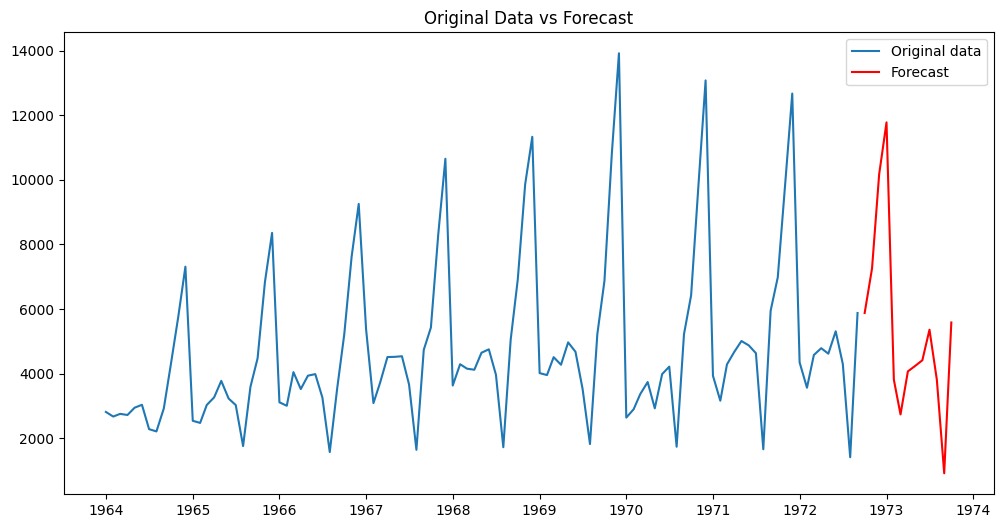

In [158]:
plt.figure(figsize=(12,6))
plt.plot(df_old, label='Original data')

forecast_index = pd.date_range(start=df_old.index[-1], periods=len(forecast)+1, freq='MS')[1:]
forecast_series = pd.Series(forecast.values, index=forecast_index)
plt.plot(forecast_series, label='Forecast', color='red')

plt.title('Original Data vs Forecast')
plt.legend()